# Demo: openEO Python Client Library

This is an illustration of using the [openEO Python Client Library](https://open-eo.github.io/openeo-python-client/)
with the openEO Platform.

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.signal
import shapely.geometry
import pathlib

import openeo
from openeo.rest.job import RESTJob
from openeo.rest.conversions import timeseries_json_to_pandas

%matplotlib inline

In [2]:
DEFAULT_FIGSIZE = (9, 6)

def show_tiff(filename:str, figsize=DEFAULT_FIGSIZE, vmin=None, vmax=None, rescale_percentile=97, add_colorbar=False):
    """Small helper to load a geotiff and visualize it"""
    with rasterio.open(filename) as ds:
        data = ds.read()

    fig, ax = plt.subplots(figsize=figsize)

    if len(data.shape) == 3:
        if data.max() > 500:
            p = np.percentile(data, rescale_percentile, axis=[1,2])
            data = data / p[:, None, None]
            data = np.clip(data, 0, 1)        
        data = np.moveaxis(data, 0, 2)
        if data.shape[2]<3:
            data = data[:,:,0]
        
    im = ax.imshow(data, vmin=vmin, vmax=vmax,cmap="RdYlGn")
    if add_colorbar:
        fig.colorbar(im, ax=ax, fraction=0.05)

out_dir = pathlib.Path("openeo-terrascope-webinar-results")
out_dir.mkdir(parents=True, exist_ok=True)

In [4]:
openeo.client_version()

'0.6.2a1'

# Create a connection

It all starts with creating a connection to the desired openEO backend as follows:

In [3]:
con = openeo.connect("https://openeo.cloud")
con

<Connection to 'https://openeo.cloud' with NullAuth>

Using this `Connection` object, we can list available data collections and inspect other metadata.

In [6]:
con.list_collections()

[{'description': 'Sentinel 1 GRD Sigma0, mosaic of all ascending relative orbits. Backscatter values are provided as natural number, not in decibel. Provided by Terrascope.\n\n Use [this viewer](https://viewer.terrascope.be/?language=en&bbox=2.8531494643539195,50.29627033037724,6.36877446435392,51.454777120718546&overlay=true&bgLayer=Satellite&date=2020-10-15&layer=CGS_S1_GRD_SIGMA0) to explore the data.',
  'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
   'temporal': {'interval': [['2015-07-06T00:00:00Z', None]]}},
  'id': 'S1_GRD_SIGMA0_ASCENDING',
  'license': 'free',
  'links': [{'href': 'https://docs.terrascope.be/#/DataProducts/Sentinel-1/ProductsOverview',
    'rel': 'alternate',
    'title': 'Product web page.'}],
  'providers': [{'name': 'Terrascope/VITO'}],
  'stac_extensions': ['datacube'],
  'stac_version': '0.9.0',
  'title': 'Sentinel 1 GRD Sigma0 product, VH, VV and angle.'},
 {'description': 'Sentinel 1 GRD Sigma0, mosaic of all descending relative orbits. Backscatter values are provided as natural number, not in decibel. Provided by Terrascope.\n\n Use [this viewer](https://viewer.terrascope.be/?language=en&bbox=2.8531494643539195,50.29627033037724,6.36877446435392,51.454777120718546&overlay=true&bgLayer=Satellite&date=2020-10-15&layer=CGS_S1_GRD_SIGMA0) to explore the data.',
  'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
   'temporal': {'interval': [['2015-07-06T00:00:00Z', None]]}},
  'id': 'S1_GRD_SIGMA0_DESCENDING',
  'license': 'free',
  'links': [{'href': 'https://docs.terrascope.be/#/DataProducts/Sentinel-1/ProductsOverview',
    'rel': 'alternate',
    'title': 'Product web page.'}],
  'providers': [{'name': 'Terrascope/VITO'}],
  'stac_extensions': ['datacube'],
  'stac_version': '0.9.0',
  'title': 'Sentinel 1 GRD Sigma0 product, VH, VV and angle.'},
 {'description': 'FAPAR Level-3 product at 10m resolution. Covers selected areas globally. This FAPAR is derived directly from ESA L2A products. The FAPAR quantifies the fraction of the solar radiation absorbed by live leaves for the photosynthesis activity. Then, it refers only to the green and alive elements of the canopy. The FAPAR depends on the canopy structure, vegetation element optical properties, atmospheric conditions, and angular configuration. \n\nFAPAR is recognized as an Essential Climate Variable (ECV) by the Global Climate Observing System (GCOS).',
  'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
   'temporal': {'interval': [['2015-07-06T00:00:00Z', None]]}},
  'id': 'TERRASCOPE_S2_FAPAR_V2',
  'license': 'proprietary',
  'links': [{'href': 'https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice',
    'rel': 'license'},
   {'href': 'https://services.terrascope.be/catalogue/description?collection=urn:eop:VITO:TERRASCOPE_S2_FAPAR_V2',
    'rel': 'alternate'},
   {'href': 'https://viewer.terrascope.be/?language=nl&bbox=0.9339867511378304,50.14520994379217,6.207424251137831,51.77292299745045&overlay=false&bgLayer=MapBox&date=2019-02-25T03:17:15.000Z&layer=CGS_S2_FAPAR',
    'rel': 'alternate'}],
  'providers': [{'name': 'VITO, on behalf of the Belgian Science Policy Office (BELSPO).',
    'roles': ['producer', 'licensor'],
    'url': 'https://terrascope.be'}],
  'stac_extensions': ['datacube'],
  'stac_version': '0.9.0',
  'title': 'Sentinel-2 FAPAR L3 V2'},
 {'description': 'NDVI Level-3 product at 10m resolution. Covers selected areas globally. This NDVI is derived directly from ESA L2A products.',
  'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
   'temporal': {'interval': [['2015-07-06T00:00:00Z', None]]}},
  'id': 'TERRASCOPE_S2_NDVI_V2',
  'license': 'proprietary',
  'links': [{'href': 'https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice',
    'rel': 'license'},
   {'href': 'https://services.terrascope.be/catalogue/description?collection=urn:eop:VITO:TERRASCOPE_S2_NDVI_V2',
    'rel': 'alternate'},
   {'href': 'https://viewer.terrascope.be/?language=nl

In [6]:
# con.describe_collection("TERRASCOPE_S2_TOC_V2")

In [7]:
# con.list_processes()

## Authentication with OpenID Connect

To be able to do actual processing, we have to authenticate first, 
so that the backend knows which user is using which processing resources.

We can authenticate with OpenID Connect easily with the following method.
It will first attempt to use existing refresh tokens
and if that failed, the "device code" flow will be initiated.

In [9]:
con.authenticate_oidc(provider_id="egi")

Authenticated using refresh token.


<Connection to 'https://openeo.vito.be/openeo/1.0/' with BearerAuth>

To see if authentication worked properly, we can inspect the user information that the backend received:

In [8]:
con.describe_account()["info"]["name"]

'Jeroen Dries'

# General workflow

We start easy by just requesting Sentinel-2 RGB data for a small bounding box.

First we build the query or algorithm by constructing a data cube.


In [9]:
bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
bands = ["B04", "B03", "B02"]
dates = ("2021-03-06", "2021-03-07")

In [10]:
cube = con.load_collection("TERRASCOPE_S2_TOC_V2", bands=bands)
cube = cube.filter_bbox(bbox=bbox)
cube = cube.filter_temporal(dates)

The thing we constructed here is a `DataCube` object, which is a symbolic representation of the operations we want to do:

In [11]:
cube

Now "execute" the algorithm by triggering a synchronous download:

In [12]:
%%time
cube.download(out_dir / "basic.tiff", format="GTIFF")

CPU times: user 38.5 ms, sys: 14.5 ms, total: 53 ms
Wall time: 8.16 s


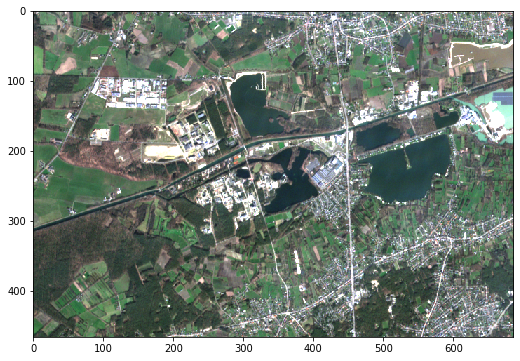

In [32]:
show_tiff(out_dir / "basic.tiff")

# "Band math": NDVI

To illustrate the "band math" feature of the openEO Python Client Libaray
we will calculate the NDVI (Normalized Difference Vegetation Index)
which is a popular indicator for the amount of vegation based on near-infrared ("NIR") and red bands of Sentinel-2:

$$ \mathrm{NDVI} = \frac{\mathrm{NIR} - \mathrm{Red}}{\mathrm{NIR} + \mathrm{Red}} $$


In [14]:
bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
dates = ("2021-03-06", "2021-03-07")
bands = ["B04", "B08"]

# Note that we can specify bounding box and temporal extent directly in the `load_collection` process
cube = con.load_collection("TERRASCOPE_S2_TOC_V2", spatial_extent=bbox, temporal_extent=dates, bands=bands)

Pick the red and NIR bands:

In [15]:
red = cube.band("B04")
nir = cube.band("B08")

Use mathematical operators on these bands, to calculate the NDVI.

In [16]:
ndvi = (nir - red) / (nir + red)

Note that the above expression does not involve actual calculations (like when you use floats or numpy arrays).
We are just working with symbolic representations that we assemble together as desired to construct an algorithm.
For example: the `ndvi` variable is just a `DataCube` object:

In [17]:
ndvi

If you're interested, you can inspect the JSON-representation of the DataCube we will send to the backend:

In [19]:
# print(ndvi.to_json())

Now, execute this data cube on the backend and download the result:

In [18]:
%time ndvi.download(out_dir / "ndvi.tiff", format="GTiff")

CPU times: user 22.7 ms, sys: 3.04 ms, total: 25.8 ms
Wall time: 10.6 s


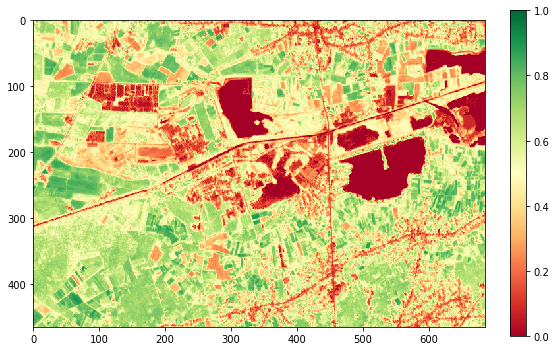

In [35]:
show_tiff(out_dir / "ndvi.tiff", vmin=0, vmax=1, add_colorbar=True)

# Cloud masking

On some dates, the observation can be ruined because of clouds and we want to filter out those pixels.
We can do that with the help of the scene classification layer `SCL` of the `TERRASCOPE_S2_TOC_V2` collection.

Take this date for example:

In [36]:
dates = ("2020-07-21", "2020-07-22")

bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
bands = ["B04", "B03", "B02"]

cube = con.load_collection("TERRASCOPE_S2_TOC_V2", spatial_extent=bbox, temporal_extent=dates, bands=bands)
%time cube.download(out_dir / "basic-clouded.tiff", format="GTIFF")

CPU times: user 37.8 ms, sys: 15.7 ms, total: 53.4 ms
Wall time: 7.35 s


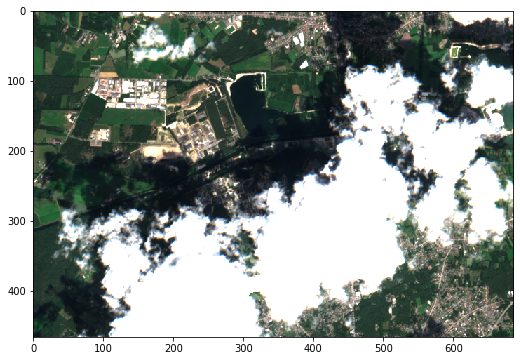

In [37]:
show_tiff(out_dir / "basic-clouded.tiff", rescale_percentile=70)

Let's load the data to calculate the NDVI and to get the scene classification.

In [38]:
bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
dates = ("2020-07-21", "2020-07-22")

bands = ["B04", "B08", "SCL"]

cube = con.load_collection("TERRASCOPE_S2_TOC_V2", temporal_extent=dates, spatial_extent=bbox, bands=bands)

In [39]:
red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)
%time ndvi.download(out_dir / "ndvi-clouded.tiff", format="GTiff")

CPU times: user 20.5 ms, sys: 6.75 ms, total: 27.2 ms
Wall time: 8.39 s


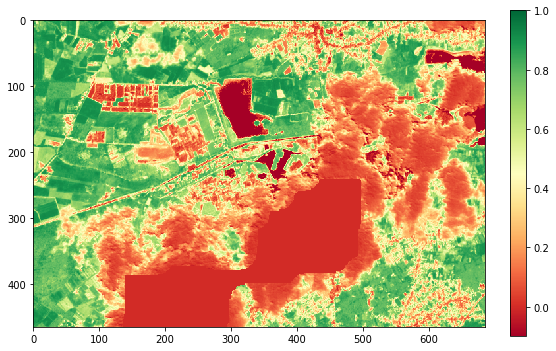

In [41]:
show_tiff(out_dir / "ndvi-clouded.tiff", vmin=-0.1, vmax=1, add_colorbar=True)

The clouds are clearly ruining the NDVI data.


To filter out the cloudy pixels: let's create a cloud mask based on the scene classification band.

In [42]:
classification = cube.band("SCL")

Build a mask to keep these classes:

- 4: vegetation
- 5: (non vegetated)

and remove the rest (clouds, cloud shadows, water, snow, ...)

In [43]:
mask = ~ ((classification == 4) | (classification == 5))

In [44]:
%time mask.download(out_dir / "mask-orig.tiff", format="GTiff")

CPU times: user 7.97 ms, sys: 3.39 ms, total: 11.4 ms
Wall time: 6.78 s


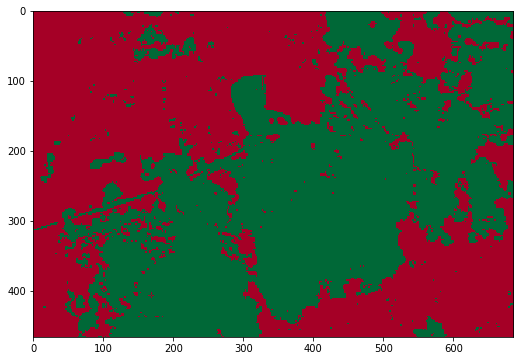

In [45]:
show_tiff(out_dir / "mask-orig.tiff")

The dark parts of this image are the pixels that were classified as class 4 or 5, and the other (light) pixels are the pixels we want to discard (replace with `NaN` = not a value).

Note that this mask image is a but noise and rough. We better expand the light area a bit to be a bit more conservative about which pixels are the usable ones.
We can implement this "dilation" by applying a gaussian blur and threshold opeartion.

First, create a simple gaussian kernel:

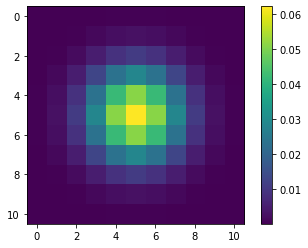

In [6]:
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()
im = plt.imshow(kernel)
plt.colorbar(im);

Convolve the mask image with the kernel and apply a threshold (note that we can use a regular comparison operator here):

In [47]:
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

In [48]:
mask.download(out_dir / "mask.tiff", format="GTiff")

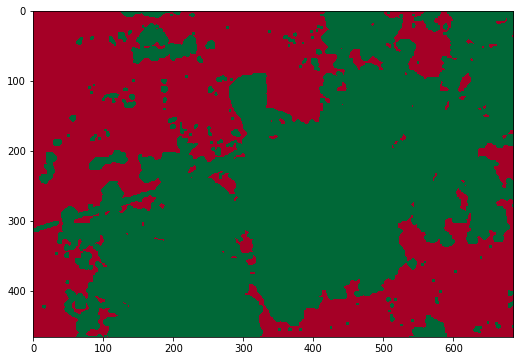

In [49]:
show_tiff(out_dir / "mask.tiff")

Great, we have a cleaner mask now.

Let's apply this mask to NDVI data. The masked pixels will get a `NaN` value.

In [50]:
red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

masked_ndvi = ndvi.mask(mask)

In [51]:
masked_ndvi.download(out_dir / "ndvi-masked.tiff", format="GTIFF")

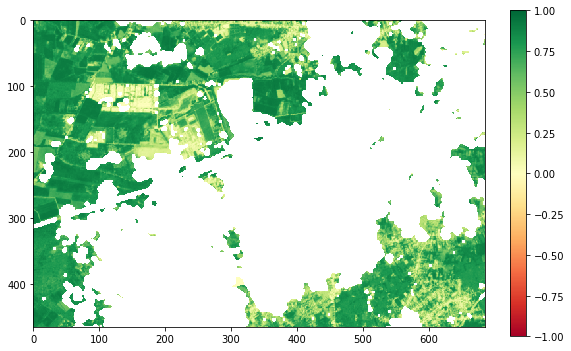

In [52]:
show_tiff(out_dir / "ndvi-masked.tiff", vmin=-1, vmax=1, add_colorbar=True)

The `NaN` values are show as white in this image, so that looks as desired.

# Batch Jobs

If we want to cover a larger time window (or a larger geographical area), 
the synchronous `DataCube.download()` request we are doing above can take longer
because we are processing more data on the backend. 
This increases the risk that we will hit timeouts or other network issues.

It is therefor recommended to use batch jobs instead of synchronous execution 
for "large" requests (in terms of temporal or geographical coverage).
Let's illustrate that here with a time window of a couple of years:

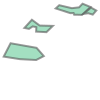

In [4]:
dates = ("2018-01-01", "2021-03-20")

fields_geojson = '{"type": "GeometryCollection", "geometries": [{"type": "Polygon", "coordinates": [[[5.055945487931457, 51.222709834076504], [5.064972484168688, 51.221122565090525], [5.064972484168688, 51.221122565090525], [5.067474954083448, 51.218249806779134], [5.064827929485983, 51.21689628072789], [5.05917785594747, 51.217191909908095], [5.053553857094518, 51.21807492332223], [5.055945487931457, 51.222709834076504]]]}, {"type": "Polygon", "coordinates": [[[5.063345886679116, 51.23087606640057], [5.06604742694687, 51.22886710731809], [5.070627820472246, 51.22874440121892], [5.068403609708207, 51.22657208381529], [5.064823257492447, 51.22676051738515], [5.064892324615199, 51.2283032878514], [5.063641745941974, 51.2285757299238], [5.062340811262595, 51.227722351687945], [5.06076005158084, 51.228042312276536], [5.063345886679116, 51.23087606640057]]]}, {"type": "Polygon", "coordinates": [[[5.07163184674986, 51.23481147556147], [5.076706025697324, 51.23317590781036], [5.077828303041866, 51.233226237184724], [5.078024733866917, 51.23263978271262], [5.080771081607657, 51.23259097170763], [5.083734842574312, 51.23530464074437], [5.080957826735458, 51.23646091560258], [5.079752631651647, 51.23519531038643], [5.077238400183506, 51.23490534677628], [5.072856439300575, 51.23593546777778], [5.07163184674986, 51.23481147556147]]]}, {"type": "Polygon", "coordinates": [[[5.083897244679042, 51.23510639883143], [5.081302408741335, 51.232922477780846], [5.082963802194108, 51.233146058575876], [5.084497702305552, 51.232672717580655], [5.085732850338428, 51.2340852086282], [5.083897244679042, 51.23510639883143]]]}]}'
fields = shapely.geometry.shape(json.loads(fields_geojson))
fields

In [7]:
cube = con.load_collection("TERRASCOPE_S2_TOC_V2", bands=["B04", "B08", "SCL"])
cube = cube.filter_temporal(dates)

classification = cube.band("SCL")
mask = ~ ((classification == 4) | (classification == 5))
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

masked_ndvi = ndvi.mask(mask)

masked_timeseries = masked_ndvi.aggregate_spatial(geometries=fields, reducer="mean")

# We want to download the result in JSON format, which we have to specify here:
masked_timeseries = masked_timeseries.save_result(format="JSON")

We can now submit this a batch job:

In [10]:
job = masked_timeseries.send_job()

In [11]:
job.status()

'created'

The job is just created at the backend, it is not started automatically. We have to start it explicitly:

In [12]:
job.start_job()

In [14]:
job.status()

'queued'

We now have to wait for the job status to become "finished".
The openEO Python Client Library provides a way to actively wait for that.
Let's first stop the job we start.


In [15]:
job.stop_job()

In [16]:
job.status()

'canceled'

The `DataCube.execute_batch` helper method allows you to execute your algorithm as a batch job,
taking care of submitting and starting it, polling its status regularly,
and actively waiting till it is "finished" (or failed).

In [17]:
job = masked_timeseries.execute_batch()

0:00:00 Job 'b70dc566-e80a-4a61-9149-020d19a80457': send 'start'
0:00:36 Job 'b70dc566-e80a-4a61-9149-020d19a80457': queued (progress N/A)
0:00:42 Job 'b70dc566-e80a-4a61-9149-020d19a80457': queued (progress N/A)
0:00:49 Job 'b70dc566-e80a-4a61-9149-020d19a80457': queued (progress N/A)
0:00:57 Job 'b70dc566-e80a-4a61-9149-020d19a80457': queued (progress N/A)
0:01:08 Job 'b70dc566-e80a-4a61-9149-020d19a80457': queued (progress N/A)
0:01:21 Job 'b70dc566-e80a-4a61-9149-020d19a80457': queued (progress N/A)
0:01:37 Job 'b70dc566-e80a-4a61-9149-020d19a80457': queued (progress N/A)
0:01:56 Job 'b70dc566-e80a-4a61-9149-020d19a80457': queued (progress N/A)
0:02:21 Job 'b70dc566-e80a-4a61-9149-020d19a80457': queued (progress N/A)
0:02:51 Job 'b70dc566-e80a-4a61-9149-020d19a80457': running (progress N/A)
0:03:30 Job 'b70dc566-e80a-4a61-9149-020d19a80457': running (progress N/A)
0:04:17 Job 'b70dc566-e80a-4a61-9149-020d19a80457': running (progress N/A)
0:05:16 Job 'b70dc566-e80a-4a61-9149-020d19a

In [18]:
job.status()

'finished'

When it's finished we can download the result. 
Note that a batch job can have multiple output files (assets), which is another advantage compared to synchronous download (which can only have a single result asset).

In [19]:
results = job.get_results()
results

<JobResults for job 'b70dc566-e80a-4a61-9149-020d19a80457'>

Because there is just one asset, we can download it easily as follows:

In [20]:
results.download_file(out_dir / "timeseries-large.json")

PosixPath('openeo-terrascope-webinar-results/timeseries-large.json')

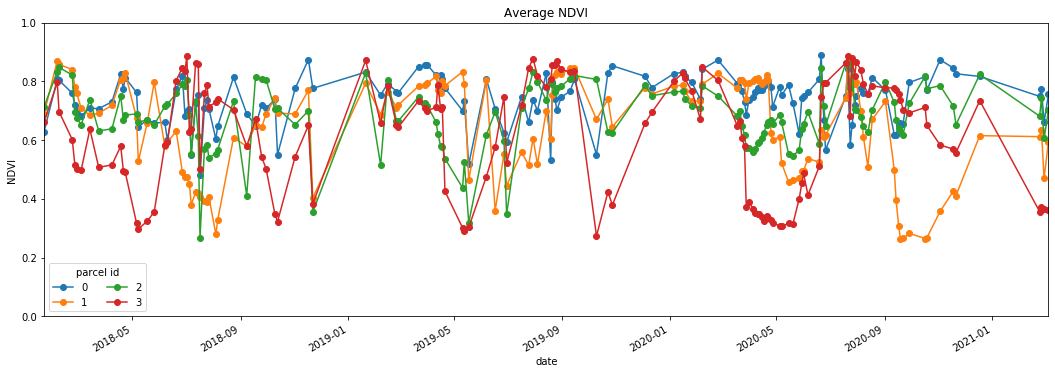

In [25]:

def plot_timeseries(filename):
    """Helper to plot the timeseries directly from JSON file"""
    with open(filename) as f:
        ts = timeseries_json_to_pandas(json.load(f)).dropna()
    ts.index = pd.to_datetime(ts.index)
    fig, ax = plt.subplots(figsize=(18,6))
    ts.plot(marker='o', ax=ax)
    ax.set_title("Average NDVI"); ax.set_ylabel("NDVI");ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

    
plot_timeseries(out_dir / "timeseries-large.json")

In this multi-year view of the NDVI timeseries we can observe some seasonal cycles and ploughing/harvesting operations.